[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb)

# Parametersensivitätsanalyse für Genesungsrate lambda_median
## Deutschland vom 10.03.2020 bis 10.06.2020

Initial definieren wir wie viele Threads wir bei dem MCMC-Sampling gleichzeitig rechnen lassen wollen (`%env OMP_NUM_Thread`). Zudem soll das `covid19_inference`-Modul installiert werden. Ferner stellen wir mit `%load_ext autoreload` und `%autoreload 2` sicher, dass automatisch die Module vor der Ausführung des Codes nachgeladen werden. Das kann insbesondere dann hilfreich sein, wenn wir Änderungen durchführen, den Kernel aber nicht neustarten wollen. Zusätzlich wird das `pytensor`-Modul geladen sowie das `pymc`. Vor allem `pymc` spielt in der Bayes'schen Inferenz eine wichtige Rolle.

In [1]:
# use 1 thread per chain
%env OMP_NUM_THREADS=1

!pip install covid19_inference
%load_ext autoreload
%autoreload 2
import pytensor
#pytensor.config.mode = "NUMBA"
import pymc as pm

env: OMP_NUM_THREADS=1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00




# Beispiel für Deutschland
Hier verwenden wir JHU-Daten.


An dieser Stelle werden zunächst die Voraussetzungen geladen. Diese sollten zuvor installiert worden sein, damit wir diese auch importieren können.


In [2]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytensor.tensor as at
import pymc as pm
import timeit

Nun importieren wir das installierte Modul `covid19_inference`

In [3]:

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Datengenerierung

Als nächstes wir das Datenset geladen bzw. heruntergeladen. Es gibt insgesamt viele möglichen Download-Ressourcen, jedoch verwenden wir in diesem Fall den von der John Hopkins Universität.
[Github-Repository Link für die csv-Datei](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)


In [4]:
jhu = (
    cov19.data_retrieval.JHU()
)
jhu.download_all_available_data(force_download=False)

Wir können auf die Daten nun mithilfe von jhu.daten zugreifen.

Wir erstellen erstmal einen intialen Zeitraum vom 10.03.2020 bis zum 16.04.2020


In [5]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime(2020, 6, 10)

Hier werden die totalen Fallzahlen bzw. neu gemeldeten Fallzahlen aus dem Datensatz gefiltert. Wir geben dabei den Üebrgabeparameter `country="Germany"` an, da wir die Datenanalyse für Deutschland durchführen wollen.

In [6]:
total_cases_obs = jhu.get_total(
    country="Germany", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    country="Germany", data_begin=bd, data_end=ed
)



## Modellerstellung
Um das Modell zu erstellen, werden zunächst einige Parameter gesetzt.


*   diff_data_sim
*   num_days_forecast




In [7]:
diff_data_sim = 16
num_days_forecast = 10

*   `prior_date_mild_dist_begin`: Wir setzen einen Zeitpunkt fest für den Beginn der ersten politischen Maßnahme
*   `prior_date_strong_dist_begin`: Wir setzen einen Zeitpunkt für die nächste politische Maßnahme
*   `prior_date_contact_ban_begin`: Wir setzen einen Zeitpunkt für das Einsetzen der ersten Kontaktsperre

In [8]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)


*   `change_points`: Ein Dictionary, das jeweils Einträge für die 3 politischen Maßnahmen enthält. Dazu werden jeweils Parameter gesetzt, wie der Prior für die Ansteckungsrate λ
*   pr_mean_date_transient
*   pr_sigma_date_transient
*   pr_median_lambda
*   pr_sigma_lambda

In [9]:
change_points1 = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,

    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [10]:
change_points2 = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.4,
        pr_sigma_lambda=1,

    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 4,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 ,
        pr_sigma_lambda=1,
    ),
]

In [11]:
change_points3 = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.1,
        pr_sigma_lambda=1,

    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 16 / 2,
        pr_sigma_lambda=1,
    ),
]

*  `params_model:` Ein Dictionary, das verschiedene Parameter enthält. Zum Einen die neu gemeldeten Fallzahlen, aber auch die Länge der Vorhersage sowie die Anzahl der Population
*   `pr_delay`: Hier wollen wir den Prior setzen für den Parameter der Meldeverzögerung


In [12]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

In [13]:
# we want to create multiple models with the different change points
def create_model(change_points, params_model):
    with cov19.Cov19Model(**params_model) as this_model:
        lambda_t_log = cov19.model.lambda_t_with_sigmoids(
            pr_median_lambda_0=0.4,
            pr_sigma_lambda_0=0.5,
            change_points_list=change_points,
            name_lambda_t="lambda_t",
        )
        mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu)
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
        )
        new_cases = cov19.model.week_modulation(cases=new_cases)
        pm.Deterministic("new_cases",new_cases)
        cov19.model.student_t_likelihood(cases=new_cases)
    return this_model

In [14]:
mod_a = create_model(change_points1, params_model)
mod_b = create_model(change_points2, params_model)
mod_c = create_model(change_points3, params_model)

Mit dem zuvor definieren params_model wollen wir nun ein sogenanntes Cov19-Modell erstellen. Dazu initialiseren wir dieses Objekt mit einem Array für die zeitabhängige Infektionsrate λ (`lambda_t_log`). Ferner setzen wir die Priori-Verteilung der Genesungsrate μ. Zudem wird auch `I_begin` durch einen Prior bestimmt.
Um das SIR-Modell zu erstellen benötigt es dann die zeitabhängige Infektionsrate (`lambda_t_log`), die Genesungsrate μ und `I_begin`. Wir speichern das SIR-Modell in der Variablen `new_cases`. Diese wird dann verändert mit der `delay`-Funktion, in der wir die Meldungen um einen lognormal Verzögerungswert verändern. Als letztes wird noch der Wochenendeffekt betrachtet. Hier wird die Funktion `week_modulation` auf das SIR-Modell angewandt.
Zuletzt wird noch die `student_t_likelihoo`d-Funktion auf das SIR-Modell angewandt.


In [15]:
tr_a = pm.sample(model=mod_a, tune=50, draws=100, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b, tune=50, draws=100, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c, tune=50, draws=100, init="advi+adapt_diag")

[Inference data with groups:
	> posterior
	> sample_stats
	> observed_data, Inference data with groups:
	> posterior
	> sample_stats
	> observed_data, Inference data with groups:
	> posterior
	> sample_stats
	> observed_data]


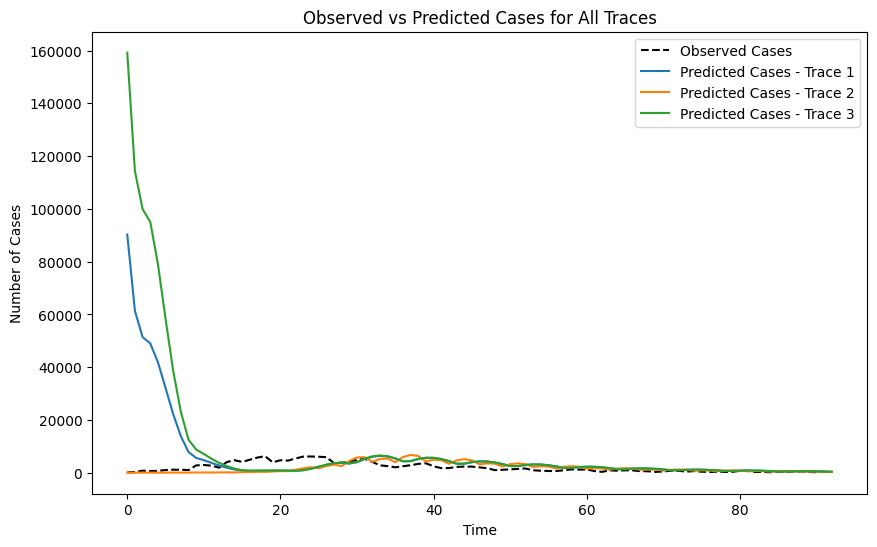

In [16]:
observed_cases = new_cases_obs
trace_list = []
trace_list.append(tr_a)
trace_list.append(tr_b)
trace_list.append(tr_c)
print(trace_list)

# Annahme: observed_cases und trace_list sind verfügbar
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(observed_cases))

# Plot für beobachtete Fälle
plt.plot(time_axis, observed_cases, label='Observed Cases', linestyle='--', color='black')


# Plot für vorhergesagte Fälle für alle Traces
for i, trace in enumerate(trace_list):
    predicted_cases = trace.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)]
    plt.plot(time_axis, predicted_cases, label=f'Predicted Cases - Trace {i + 1}')

# Legende und Achsentitel
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Cases')
plt.title('Observed vs Predicted Cases for All Traces')

# Anzeige des Plots
plt.show()
